# 匯入FaceNet model

In [1]:
# example of loading the keras facenet model
from keras.models import load_model
# import facenet_keras
# model = facenet_keras.facenet()
# load the model
model  =  load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

2021-11-29 19:26:51.013409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 19:26:51.013435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-29 19:26:54.510610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-29 19:26:54.510648: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-29 19:26:54.510675: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cocoIsGood): /proc/driver/nvidia/version does not exist
2021-11-29 19:26:54.510859: I tensorflow/core/platform/cpu_feature

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


## 確認mtcnn版本

In [2]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


# 檢測人臉

In [3]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename,  required_size=(160,  160)):
    # load image from file
    image  =  Image.open(filename)
    # convert to RGB, if needed
    image  =  image.convert('RGB')
    # convert to array
    pixels  =  asarray(image)
    # create the detector, using default weights
    detector  =  MTCNN()
    # detect faces in the image
    results  =  detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1,  y1  =  abs(x1),  abs(y1)
    x2,  y2  =  x1  +  width,  y1  +  height
    # extract the face
    face  =  pixels[y1:y2,  x1:x2]
    # resize pixels to the model size
    image  =  Image.fromarray(face)
    image  =  image.resize(required_size)
    face_array  =  asarray(image)
    return  face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
    faces  =  list()
    # enumerate files
    for  filename in  listdir(directory):
        # path
        path  =  directory  +  filename
        # get face
        face  =  extract_face(path)
        # store
        faces.append(face)
    return  faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X,  y  =  list(),  list()
    # enumerate folders, on per class
    for  subdir in  listdir(directory):
        # path
        path  =  directory  +  subdir  +  '/'
        # skip any files that might be in the dir
        if  not  isdir(path):
            continue
        # load all faces in the subdirectory
        faces  =  load_faces(path)
        # create labels
        labels  =  [subdir for  _  in  range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s'  %  (len(faces),  subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return  asarray(X),  asarray(y)

## dataset 改為 1,0兩分類

In [4]:
# load train dataset
trainX,  trainy  =  load_dataset('./archive/train/') 
print(trainX.shape,  trainy.shape)
# load test dataset
testX,  testy  =  load_dataset('./archive/val/')
# save arrays to one file in compressed format
savez_compressed('./5-celebrity-faces-dataset.npz',  trainX,  trainy,  testX,  testy)

>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling


# 創建人臉嵌入

In [5]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model,  face_pixels):
    # scale pixel values
    face_pixels  =  face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean,  std  =  face_pixels.mean(),  face_pixels.std()
    face_pixels  =  (face_pixels  -  mean)  /  std
    # transform face into one sample
    samples  =  expand_dims(face_pixels,  axis=0)
    # make prediction to get embedding
    yhat  =  model.predict(samples)
    return  yhat[0]

## dataset.npz匯入 跑model

In [6]:
# load the face dataset
data  =  load('./5-celebrity-faces-dataset.npz')
trainX,  trainy,  testX,  testy  =  data['arr_0'],  data['arr_1'],  data['arr_2'],  data['arr_3']
print('Loaded: ',  trainX.shape,  trainy.shape,  testX.shape,  testy.shape)
# load the facenet model
model  =  load_model('./facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX  =  list()
for  face_pixels in  trainX:
    embedding  =  get_embedding(model,  face_pixels)
    newTrainX.append(embedding)
newTrainX  =  asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX  =  list()
for  face_pixels in  testX:
    embedding  =  get_embedding(model,  face_pixels)
    newTestX.append(embedding)
newTestX  =  asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('./5-celebrity-faces-embeddings.npz',  newTrainX,  trainy,  newTestX,  testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
(93, 128)
(25, 128)


# 執行人臉分類

In [7]:
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data  =  load('./5-celebrity-faces-embeddings.npz')
trainX,  trainy,  testX,  testy  =  data['arr_0'],  data['arr_1'],  data['arr_2'],  data['arr_3']
print('Dataset: train=%d, test=%d'  %  (trainX.shape[0],  testX.shape[0]))
# normalize input vectors
in_encoder  =  Normalizer(norm='l2')
trainX  =  in_encoder.transform(trainX)
testX  =  in_encoder.transform(testX)
# label encode targets
out_encoder  =  LabelEncoder()
out_encoder.fit(trainy)
trainy  =  out_encoder.transform(trainy)
testy  =  out_encoder.transform(testy)
# fit model
model  =  SVC(kernel='linear',  probability=True)
model.fit(trainX,  trainy)
# predict
yhat_train  =  model.predict(trainX)
yhat_test  =  model.predict(testX)
# score
score_train  =  accuracy_score(trainy,  yhat_train)
score_test  =  accuracy_score(testy,  yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f'  %  (score_train*100,  score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


# 繪製原始人臉和預測

Predicted: jerry_seinfeld (89.272)
Expected: jerry_seinfeld


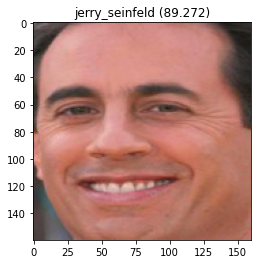

In [15]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data  =  load('./5-celebrity-faces-dataset.npz')
testX_faces  =  data['arr_2']
# load face embeddings
data  =  load('./5-celebrity-faces-embeddings.npz')
trainX,  trainy,  testX,  testy  =  data['arr_0'],  data['arr_1'],  data['arr_2'],  data['arr_3']
# normalize input vectors
in_encoder  =  Normalizer(norm='l2')
trainX  =  in_encoder.transform(trainX)
testX  =  in_encoder.transform(testX)
# label encode targets
out_encoder  =  LabelEncoder()
out_encoder.fit(trainy)
trainy  =  out_encoder.transform(trainy)
testy  =  out_encoder.transform(testy)
# fit model
model  =  SVC(kernel='linear',  probability=True)
model.fit(trainX,  trainy)
# test model on a random example from the test dataset
selection  =  choice([i  for  i  in  range(testX.shape[0])])
random_face_pixels  =  testX_faces[selection]
random_face_emb  =  testX[selection]
random_face_class  =  testy[selection]
random_face_name  =  out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples  =  expand_dims(random_face_emb,  axis=0)
yhat_class  =  model.predict(samples)
yhat_prob  =  model.predict_proba(samples)
# get name
class_index  =  yhat_class[0]
class_probability  =  yhat_prob[0,class_index]  *  100
predict_names  =  out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)'  %  (predict_names[0],  class_probability))
print('Expected: %s'  %  random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title  =  '%s (%.3f)'  %  (predict_names[0],  class_probability)
pyplot.title(title)
pyplot.show()

# 版本

In [9]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.7.12 (default, Sep 10 2021, 00:20:04) 
[GCC 9.3.0]
Version info.
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [18]:
len(newTrainX)

93

In [19]:
newTrainX

array([[ 0.83809805,  1.2204304 , -1.5851601 , ..., -0.22606471,
         0.5016964 , -0.03834889],
       [-1.1835551 , -0.2713523 , -2.1991603 , ..., -2.9651957 ,
         0.6569192 ,  2.7057748 ],
       [-1.3234568 , -1.133955  , -0.69706744, ..., -1.4861144 ,
         0.27928597,  2.4520953 ],
       ...,
       [ 0.19074044,  0.68278563, -0.42702985, ...,  2.3409336 ,
         0.5972798 , -2.2478344 ],
       [-0.047719  , -0.1345042 ,  0.42043373, ...,  0.42278805,
         1.0732008 , -1.2775187 ],
       [ 1.2530017 , -0.00298112,  0.37763542, ...,  1.207524  ,
         0.7253575 , -0.9306759 ]], dtype=float32)

In [11]:
newTestX

array([[-1.2777163 , -0.7231866 , -1.1328063 , ..., -2.02433   ,
         1.7402275 ,  1.2539915 ],
       [-0.44442257, -1.5055695 , -0.92893344, ..., -2.4234107 ,
         0.03635266,  0.7831872 ],
       [-1.1538168 ,  0.5128952 , -1.208432  , ..., -3.2265851 ,
         0.37068087,  2.354204  ],
       ...,
       [ 0.5581642 , -1.0386927 ,  0.2877702 , ...,  0.570183  ,
        -0.89292693, -0.41056398],
       [ 0.62363875,  0.12740709,  0.5318558 , ...,  0.87907195,
         0.67547274, -1.5649484 ],
       [ 0.2138499 , -0.29231024,  0.89129746, ...,  0.8904548 ,
         0.0374557 , -1.9185741 ]], dtype=float32)